In [240]:
import sys
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
# nltk.download('stopwords')
# from nltk.tokenize.punkt import PunktWordTokenizer
import gensim
from gensim.models.word2vec import Word2Vec
import re
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
from bokeh.io import output_notebook
from bokeh.plotting import show, figure
from string import digits
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.manifold        
import enchant
from enchant.checker import SpellChecker

In [241]:
path ='./'
dataset = pd.read_csv(path + 'train.csv'.format(1), engine='python')
dataset.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [242]:
dataset['toxic'][dataset['toxic'] == 1].value_counts()

1    15294
Name: toxic, dtype: int64

In [243]:
from sklearn.utils import resample

# Separate majority and minority classes
dataset_majority = dataset[dataset.toxic == 0]
dataset_minority = dataset[dataset.toxic == 1]
 
# # Upsample minority class
# dataset_minority_upsampled = resample(dataset_minority, 
#                                  replace = True,  # sample with replacement
#                                  n_samples = 144277,   # to match majority class
#                                  random_state = 123) # reproducible results
 
# # Combine majority class with upsampled minority class
# dataset_upsampled = pd.concat([dataset_majority, dataset_minority_upsampled])
 
# # Display new class counts
# dataset_upsampled.toxic.value_counts()

# Downsample majority class
dataset_majority_downsampled = resample(dataset_majority, replace = True, n_samples = len(dataset_minority),
                                        random_state = 123)

# Combine two classes
dataset_ds = pd.concat([dataset_minority, dataset_majority_downsampled])

# Shuffle dataset
dataset_ds = dataset_ds.sample(frac=1).reset_index(drop=True)

In [244]:
# reload(sys)
# sys.setdefaultencoding('ascii')

In [246]:
data_small = dataset_ds[0:1000]
# tokenize data, tolowercase, remove stopwords and remove symbols like \n
# print(dataset_ds['comment_text'].iloc[0])
# print(word_tokenize(dataset_ds['cmment_text'].iloc[0]))
tokenizer = TreebankWordTokenizer()
# print(tokenizer.tokenize(dataset_ds['comment_text'].iloc[0]))
chkr = SpellChecker("en_UK", "en_US")

def low(x):
#     x = x.decode('utf-8')
#     if type(x) != unicode:
#         x = unicode(x)
    # remove numbers
#     filter(lambda x: x.isalpha(), x)
#     x = re.sub(r'[^\w]', ' ', x)
    x = re.sub(r'[\W_]+', ' ', x)
    chkr.set_text(x)
    for err in chkr:
#         print(err.suggest())
        if len(err.suggest()) > 0:
            sug = err.suggest()[0]
            err.replace(sug)
            x = chkr.get_text()
    return x.lower()

def tok_and_rem(x):
#     if type(x) != unicode:
#         x = unicode(x)
#     s = word_tokenize(x)
    s = x.split()
    l = list(s)
    for word in s:
        if (len(word) <= 2):
            l.remove(word)
        elif word in stopwords.words('english'):
            l.remove(word)
    return l

# to lowercase and remove special characters
# dataset_ds['comment_text'] = dataset_ds['comment_text'].apply(lambda x: low(x))
data_small['comment_text'] = data_small['comment_text'].apply(lambda x: low(x))

# tokenize and remove stopwords
data_small['comment_text'] = data_small['comment_text'].apply(lambda x: tok_and_rem(x))


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [283]:
def fn(x):
    if len(x) == 0:
        x = ["something"]
    return x
data_small["comment_text"] = data_small["comment_text"].apply(lambda x: fn(x))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [284]:
# size = 64, dimensions
# sg = 1, use Skip-Gram. If zero, it will use CBOW
# window = 10, context words (10 to the left and 10 to the right)
# min_count = 3, ignore words with frequency lower than that
# seed = 42, the answer to the universe, life and everything.
# workers = 2, number of worker threads.
model = Word2Vec(sentences=data_small['comment_text'], size=100, sg=1,
                 window=10, min_count=2, seed=42,
                 workers=2)

In [285]:
# Shows the coordinates of the word ‘house’ in the vector space.
model.wv.most_similar('fuck')
# print(model.most_similar('house'))
# model.similarity('house','place')

[('sign', 0.9936554431915283),
 ('wrote', 0.993466854095459),
 ('ban', 0.991179347038269),
 ('cunt', 0.9903357028961182),
 ('warning', 0.9898945689201355),
 ('mum', 0.9897364974021912),
 ('sloppy', 0.9881573915481567),
 ('cant', 0.9878690242767334),
 ('ass', 0.9809805154800415),
 ('know', 0.9691420793533325)]

In [206]:
l = []
def merge(x):
    for i in x:
        l.append(i)
    

data_small['comment_text'].apply(lambda x: merge(x))
len(l)
len(set(l))
tstr = ' '.join(l)
print(tstr)

array([ list(['april', '2007', 'utc', 'well', 'glad', 'take', 'seriously', 'pendantic', 'twat']),
       list(['using', 'iphone', 'right', 'might', 'part', 'problem', 'get', 'computer', 'take', 'look', 'later']),
       list(['apparently', 'needs', 'look', 'situation', 'without', 'making', 'snap', 'decisions', 'looked', 'find', 'actually', 'evidence', 'whatsoever', 'death', 'threats', 'lied', 'twice', 'reason', 'deleting', 'pages', 'death', 'threats', 'page', 'clear', 'instead', 'disruptive', 'would', 'resolved', 'much', 'easily', 'mean', 'referring', 'editor', 'blocks', 'year', 'long', 'arbcom', 'parole', 'extensive', 'history', 'one', 'disruptive', 'people', 'project', 'kind', 'behavior', 'condone', 'want', 'respect', 'point', 'sheer', 'hypocrisy', 'warning', 'edit', 'summary', 'leaving', 'message', 'saying', 'utterly', 'disgust', 'pot', 'kettle', 'fill', 'rest', 'swatjester', 'son', 'defender']),
       list(['edit', 'request', 'hello', 'guys', 'fuck', 'pieces', 'shit', 'hate', 'wik

In [286]:
sent = set()
tmp = set()
for l in data_small['comment_text'].values:
    tmp = set(l)
    sent = sent.union(tmp)
# print(sent)
# print(pd.DataFrame(data_small['comment_text']).head(100))
# print(data_small['comment_text'].values)
print(len(sent))
print(sent)

7260
set(['secondly', 'bibliotecapleyades', 'whoops', 'bosses', 'foul', 'four', 'andre', 'writings', 'hanging', 'plaudits', 'comically', 'aggression', 'whose', 'buddy', 'granting', 'eligible', 'snowing', "dat's", 'contained', 'james', 'swat', 'lord', 'sorry', 'sway', 'updated', 'collaborate', 'internet', 'dell', 'stolen', 'yellow', '960', 'stabbed', 'dynasty', 'bringing', '21575756', 'look', 'dominate', 'prize', 'skills', 'companies', 'solution', 'frozen', 'convenience', 'woods', 'crotch', '0002tree', 'shows', 'ups', 'orientate', '10k', 'expanded', 'force', 'concise', 'miller', 'medieval', 'pubic', 'japanese', 'budget', 'conniption', 'likely', 'available', 'buzz', 'worthlessness', 'even', 'errors', "shapiro's", 'desirous', 'integrity', 'contributed', 'fingers', 'asia', 'hostile', 'usenet', 'new', 'net', 'increasing', 'ever', 'duran', 'med', 'meg', 'hero', 'gentiles', 'mel', 'men', 'brainwashed', 'atoms', 'reported', '108', '109', 'china', 'cult', '103', '100', '101', '107', '104', '105

In [136]:
# instance = Word2Vec(size=100, sg=1,
#                  window=10, min_count=2, seed=42,
#                  workers=2)
# instance.build_vocab(data_small['comment_text'])
# instance.build_vocab(list(set(l)))

In [287]:
print("Set length: " + str(len(sent)))
print("Vocabulary length: " + str(len(model.wv.vocab)))
for i in model.wv.vocab:
    print(i)

Set length: 7260
Vocabulary length: 3433
limited
writings
personally
foul
four
sleep
controversial
oldest
saved
aggression
forget
whose
votes
violate
unblocked
swat
whatsoever
immature
worth
plants
updated
point
epistle
penny
every
jack
multiple
vast
school
ref
companies
commons
indefinitely
nigger
disc
crotch
humps
heading
enjoy
10k
civility
force
tired
miller
consistent
guidelines
japanese
sabbath
second
street
believing
theory
even
established
errors
christ
deliberate
hate
clocked
selected
contributed
mentioned
asia
conduct
new
net
poorly
ever
told
med
kicked
hero
never
brainwashed
hundreds
reported
protection
possibility
cult
103
100
101
107
substance
forum
clarify
items
study
changed
reports
controversy
omar
browsing
military
i'm
changes
criticism
appropriately
swearing
plea
campaign
marianne
explained
reagan
replace
brought
uncivil
suffered
moral
guests
pyongyang
actions
total
forums
unit
plot
stating
would
army
browse
gloss
negative
insult
asses
music
therefore
typo
recommend
se

pakistan
knowledgeable
novgorod
219
oxford
civilized
unclear
kill
greetings
touch
polish
flavor
hacker
guys
captured
death
thinking
theorem
seems
except
improvement
blog
lets
setting
pile
treatment
republic
extensive
kingdom
jake
aspects
around
phelps
easily
read
gonna
mot
early
moi
traffic
pop
mom
using
accepted
lady
vague
dare
depot
buddies
oddly
notified
benefit
sic
nose
fully
fascist
chinese
nice
interest
jews
explaining
pacific
erase
table
images
reconsider
divine
thinks
reasons
gross
poll
confirm
epiphanies
teachings
nazi
legal
conservative
aa9skills
provides
doggy
preceding
porter
refer
biased
felt
wheat
scientific
business
poem
notable
broker
credits
1930
innocence
raul
refers
comparison
stone
central
unesco
fringe
fell
wolf
stand
act
invested
mean
road
frito
referenced
protests
flawed
image
wads
involvement
determine
apologize
jerusalem
vaughan
fast
log
hes
removing
strictly
hey
start
racist
low
italic
house
complete
regard
jun
ended
fascists
technologies
trying
longer
abused


involved
larger
leaving
suggests
opinion
chang
makes
ruin
named
addresses
pops
danger
egypt
crazy
private
addressed
names
duck
lima
tools
manipulate
standing
use
crap
che
usa
remains
illegal
beefed
management
normal
next
doubt
jonathan
chip
refusal
sort
supposedly
biblical
started
factor
improve
fuck
deserve
rubbish
baby
notability
women
customer
majority
account
balls
sanctions
ram
pac
anywhere
obvious
publications
chin
closing
averages
proof
control
links
process
purposes
high
villain
assumptions
recognized
tab
justifications
hit
onions
rape
sir
educational
united
democracy
lame
purpose
permission
differences
afc
regions
located
animal
instead
intelligent
sin
profile
puppets
alicia
blocks
farm
watch
permanent
abuse
ethnic
fits
spelling
tomato
discusses
purely
locates
light
counter
lines
robot
redundant
yoda's
chief
encyclopedia
allow
breast
erasing
chipolatas
sanctioned
bilbo
move
meter
whilst
131
pistols
including
looks
tiptoed
bunch
perfect
superior
theseus
brian
chosen
broom
winni

In [215]:
# instance.wv.most_similar('fuck')

In [141]:
# plot the word embedding
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
# all_word_vectors_matrix = instance.wv.syn0
all_word_vectors_matrix = model.wv.vectors
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)


In [142]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[model.wv.vocab[word].index])
            for word in model.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [153]:
points[points["word"] == "fuck"]

,word,x,y
2588,fuck,-55.820637,-44.855705


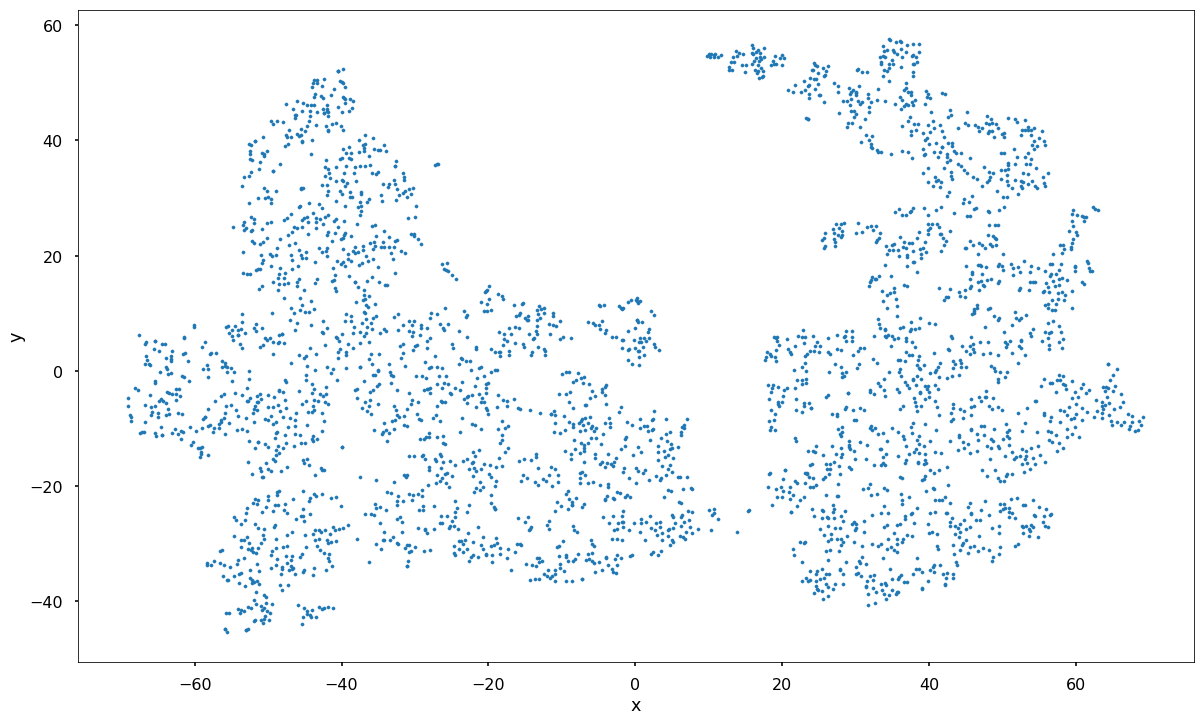

In [144]:
sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [145]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)


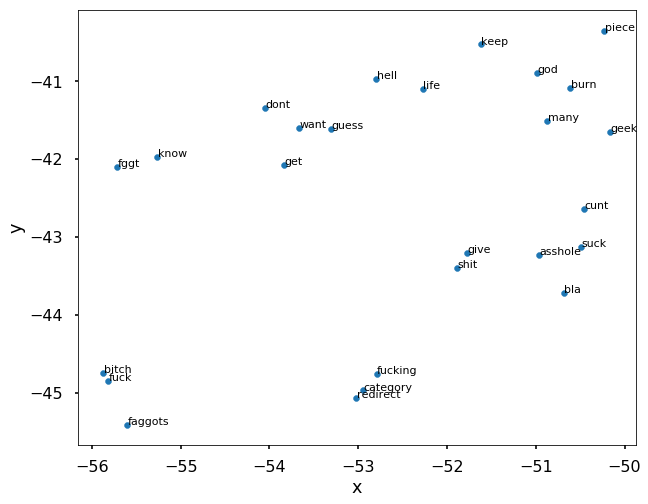

In [154]:
plot_region(x_bounds=(-60, -50), y_bounds=(-50, -40))

In [264]:
from sklearn.mixture import GMM


def fisher_vector(xx, gmm):
    """Computes the Fisher vector on a set of descriptors.
    Parameters
    ----------
    xx: array_like, shape (N, D) or (D, )
        The set of descriptors
    gmm: instance of sklearn mixture.GMM object
        Gauassian mixture model of the descriptors.
    Returns
    -------
    fv: array_like, shape (K + 2 * D * K, )
        Fisher vector (derivatives with respect to the mixing weights, means
        and variances) of the given descriptors.
    Reference
    ---------
    J. Krapac, J. Verbeek, F. Jurie.  Modeling Spatial Layout with Fisher
    Vectors for Image Categorization.  In ICCV, 2011.
    http://hal.inria.fr/docs/00/61/94/03/PDF/final.r1.pdf
    """
    xx = np.atleast_2d(xx)
    N = xx.shape[0]

    # Compute posterior probabilities.
    Q = gmm.predict_proba(xx)  # NxK

    # Compute the sufficient statistics of descriptors.
    Q_sum = np.sum(Q, 0)[:, np.newaxis] / N
    Q_xx = np.dot(Q.T, xx) / N
    Q_xx_2 = np.dot(Q.T, xx ** 2) / N

    # Compute derivatives with respect to mixing weights, means and variances.
    d_pi = Q_sum.squeeze() - gmm.weights_
    d_mu = Q_xx - Q_sum * gmm.means_
    d_sigma = (
        - Q_xx_2
        - Q_sum * gmm.means_ ** 2
        + Q_sum * gmm.covars_
        + 2 * Q_xx * gmm.means_)

    # Merge derivatives into a vector.
    return np.hstack((d_pi, d_mu.flatten(), d_sigma.flatten()))

In [288]:
def fcn(sentence):
    l = []
    for word in sentence:
        if word in model.wv.vocab.keys():
            l.append(model[word])
    return l

xx = pd.DataFrame(data_small["comment_text"].apply(lambda x: fcn(x)))

# model.wv.vocab["gate"]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [289]:
# xx_tr, xx_te = sklearn.model_selection.train_test_split(xx["comment_text"], train_size=0.5)

# Fisher vector
K = 64

gmm = GMM(n_components=K, covariance_type='diag')
gmm.fit(model.wv.vectors)

l = []
i = 0
for sentence in xx["comment_text"]:
    print(i)
    fv = fisher_vector(sentence, gmm)
    l.append(fv)
    i += 1

/home/anton/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/anton/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/anton/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/anton/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: Depreca

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67


/home/anton/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/anton/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/anton/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/anton/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWar

68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143


/home/anton/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/anton/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/anton/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/anton/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWar

144
145
146
147
148
149
150
151
152
153


ValueError: Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required.

In [290]:
for idx, sentence in enumerate(data_small["comment_text"]):
    if idx == 154:
        print(sentence)
# a 2489 !!()

['almost', 'forgot', 'paine', 'reply', 'back', 'shit', 'want', 'see', 'care', 'say', 'bitching', 'sight', 'placekicks']


In [171]:
data_small["comment_text"]

0      [april, 2007, utc, well, glad, take, seriously...
1      [using, iphone, right, might, part, problem, g...
2      [apparently, needs, look, situation, without, ...
3      [edit, request, hello, guys, fuck, pieces, shi...
4      [sanity, sake, hope, santa, gets, new, hobby, ...
5      [2012, utc, expected, liberal, rag, like, wako...
6      [barack, worst, president, ever, places, like,...
7                                     [going, eat, toes]
8      [power, hungry, administrator, likes, suck, cock]
9      [listen, stupid, wiki, basically, stealing, st...
10     [gerund, leads, ambiguity, prefect, acting, li...
11     [well, said, really, hurt, blocked, bitch, tit...
12     [sorry, sure, mean, critically, blaming, speci...
13     [proven, never, failed, strike, arguments, wou...
14     [want, styled, republic, ireland, republic, ir...
15     [also, agree, closely, related, articles, cert...
16     [well, life, goes, one, cares, one, likes, hon...
17     [soxwon, want, improve, 

In [ ]:
# try SVM on text classification with 1 label
# 
clf = svm.SVC()
X = model.wv.vectors
y = data_small["toxic"]
# cross_val_score(clf, X, y)
